In [1]:
import sys

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
# import json
import datetime
%matplotlib inline
import time

from scipy.ndimage.morphology import binary_fill_holes

sys.path.insert(0, '/home/subtle/jon/tools/SimpleElastix/build/SimpleITK-build/Wrapping/Python/Packaging/build/lib.linux-x86_64-3.5/SimpleITK')
import SimpleITK as sitk

import dicom as pydicom

import myshow

In [2]:
# modified from akshay, Subtle_SuperRes

def dicom_files(dicom_dir, normalize = False):
    
    ''' Load dicom files in a given folder
    For a given dicom directory, load the dicom files that are
    housed in the folder.
    Parameters:
    -----------
    dicom_dir : string
        name of directory to crawl through
    normalize : bool
        whether or not to normalize between 0 and 1 
    Returns:
    --------
    img_array : int16/float
        3D array of all dicom files (float if normalized)
    header : pydicom dataset
        header of the dicom scans
        
    '''
        
    # build the file list for Dicom images
    lstDCM = []
    for dirName, subdirList, fileList in os.walk(dicom_dir):
        for filename in fileList:
            if ".dcm" in filename.lower():
                lstDCM.append(os.path.join(dirName,filename))
    
    # sort the list
    lstDCM.sort()
    
    # Preallocation information
    
    # get the reference file from the first Dicom image
    hdr = pydicom.read_file(lstDCM[0])
    # matrix dimensions
    nx = int(hdr.Rows)
    ny = int(hdr.Columns)
    nz = len(lstDCM)
    
    img_array = np.zeros([nz,nx,ny], dtype=hdr.pixel_array.dtype)
    
    #%% loop through the Dicom list
    
    for filename in lstDCM:
        ds = pydicom.read_file(filename)
        img_array[lstDCM.index(filename), :, :] = np.array(ds.pixel_array)
    
    #%% Normalize the array
    
    if normalize is True:
        img_array = img_array/np.amax(img_array)
        
    return img_array, hdr

#%% Load dicom files function    

def dicom_header(dicom_dir):
    
    ''' Load dicom header from dicom files in a given folder
    For a given dicom directory, load the dicom header that are
    housed in the folder. Same function as load_dicom_files 
    but only includes header
    Parameters:
    -----------
    dicom_dir : string
        name of directory to crawl through
    Returns:
    --------
    header : pydicom dataset
        header of the dicom scans
    lstDcm : pydicom list dataset
        list of dicom files in folder
    fileOut : list
        list of full locations of all dicoms
        
    '''
        
    # build the file list for Dicom images
    lstDCM = []
    fileOut = []
    for dirName, subdirList, fileList in os.walk(dicom_dir):
        for filename in fileList:
            if ".dcm" in filename.lower():
                lstDCM.append(os.path.join(dirName,filename))
                fileOut.append(filename)

    
    # sort the list
    lstDCM.sort()
    fileOut.sort()
    
    # Preallocation information
    
    # get the reference file from the first Dicom image
    hdr = dicom.read_file(lstDCM[0])
        
    return hdr, lstDCM, fileOut

In [3]:
def imshow3(ims, axis=0, cmap='gray'):
    n = ims.shape[axis]
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(np.take(ims, i, axis=axis), cmap=cmap)
        
def simshow(sitk_image, cmap='gray'):
    plt.imshow(sitk.GetArrayViewFromImage(sitk_image), cmap=cmap)
    
def imshowreg(im0, im1, title=None):
    im0n = (im0 - np.min(im0))
    im1n = (im1 - np.min(im1))
    im0n = im0n / np.max(im0n)
    im1n = im1n / np.max(im1n)
    im = np.stack((im0n, im1n, 0*im1n), axis=2)
    plt.subplot(1,2,1)
    plt.imshow(im)
    if title is not None:
        plt.title('{} (overlay)'.format(title))
    plt.subplot(1,2,2)
    plt.imshow(np.abs(im0n - im1n))
    if title is not None:
        plt.title('{} (diff)'.format(title))
        
def myshow3d(im, title=None, margin=0.05, dpi=80, figsize=None ):
    myshow.myshow3d(sitk.GetImageFromArray(im), title=title, margin=margin, dpi=dpi, figsize=figsize)

## load data

In [4]:
path_zero = '/home/subtle/Data/Stanford/lowcon/Patient_0435/8_AX_BRAVO'
path_low = '/home/subtle/Data/Stanford/lowcon/Patient_0435/11_AX_BRAVO_+C_pre_load_10%'
path_full = '/home/subtle/Data/Stanford/lowcon/Patient_0435/14_AX_BRAVO_+C'


In [5]:
ims_zero, hdr_zero = dicom_files(path_zero)
ims_low, hdr_low = dicom_files(path_low)
ims_full, hdr_full = dicom_files(path_full)

print(ims_zero.shape, ims_low.shape, ims_full.shape)

(168, 512, 512) (168, 512, 512) (168, 512, 512)


## grab some images to train

(168, 3, 512, 512)


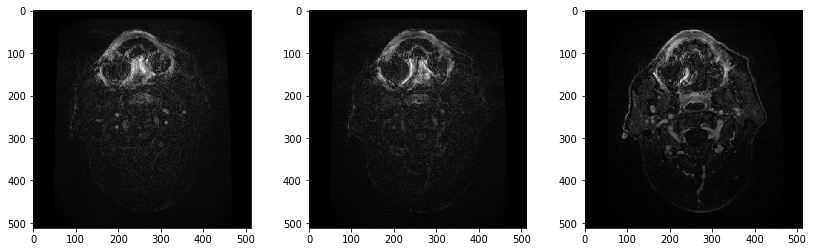

In [6]:
idx_train = np.arange(ims_zero.shape[0])
# idx_train = np.arange(20, 120)
ims = np.stack((ims_zero[idx_train,:,:], ims_low[idx_train,:,:], ims_full[idx_train,:,:]), axis=1)
print(ims.shape)
plt.figure(figsize=(14,4))
imshow3(ims[0,:,:,:])

In [7]:
myshow3d(ims[:,0,:,:].squeeze(), figsize=(5,5))

interactive(children=(IntSlider(value=83, description='z', max=167), Output()), _dom_classes=('widget-interact…

## mask

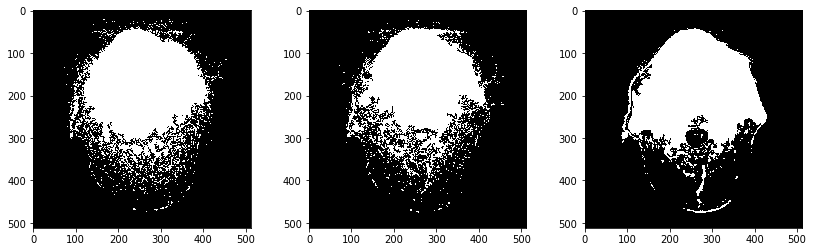

interactive(children=(IntSlider(value=83, description='z', max=167), Output()), _dom_classes=('widget-interact…

In [8]:
N, n, nx, ny = ims.shape
# n = ims.shape[1] # number of contrast images, including target (probably 3)
# N = ims.shape[0] # number of examples (probably hundreds)

MASK_VAL = .08
mask = ims > (MASK_VAL * np.amax(ims, axis=(2,3))[:,:,None,None])
# fill holes in mask
mask = binary_fill_holes(mask.reshape((n*N*nx, ny))).reshape((N, n, nx, ny))
plt.figure(figsize=(14,4))
imshow3(mask[0,:,:,:])

myshow3d(mask[:,0,:,:].astype(np.float).squeeze(), figsize=(5,5))

## alternative mask with simpleITK

In [9]:
# otsu_filter = sitk.OtsuThresholdImageFilter()
# otsu_filter.SetInsideValue(0)
# otsu_filter.SetOutsideValue(1)
# im = sitk.GetImageFromArray(ims[0,0,:,:])
# # segI = sitk.BinaryThreshold(im, lowerThreshold=0, upperThreshold=400, insideValue=1, outsideValue=0)
# segI = otsu_filter.Execute(im)
# seg = binary_fill_holes(sitk.GetArrayFromImage(segI))
# print(seg.shape)
# plt.imshow(seg)
# print(otsu_filter.GetThreshold() )


In [27]:
im0 = np.squeeze(ims[:,0,:,:] * mask[:,0,:,:])
im1 = np.squeeze(ims[:,1,:,:] * mask[:,1,:,:])

sim0 = sitk.GetImageFromArray(im0)
sim1 = sitk.GetImageFromArray(im1)

## image scaling

In [28]:
 def scale_im(im_fixed, im_moving, levels=1024, points=7, mean_intensity=True, verbose=True):
    """SimpleITK image intensity normalization. Scale im_moving to im_fixed"""
    
    sim0 = sitk.GetImageFromArray(im_fixed)
    sim1 = sitk.GetImageFromArray(im_moving)
    
    hm = sitk.HistogramMatchingImageFilter()
    hm.SetNumberOfHistogramLevels(levels)
    hm.SetNumberOfMatchPoints(points)

    if mean_intensity:
        hm.ThresholdAtMeanIntensityOn()


    if verbose:
        print('image intensity normalization')
        tic = time.time()
    
    sim_out = hm.Execute(sim1, sim0)
    
    if verbose:
        toc = time.time()
        print('scaling done, {:.3} s'.format(toc - tic))

    im_out = sitk.GetArrayFromImage(sim_out)

    return im_out

In [29]:
# matcher = sitk.HistogramMatchingImageFilter()
# matcher.SetNumberOfHistogramLevels(1024)
# matcher.SetNumberOfMatchPoints(7)
# matcher.ThresholdAtMeanIntensityOn()


# sim_res = matcher.Execute(sim1,sim0)
# im_res = sitk.GetArrayFromImage(sim_res)

im1_scaled = scale_im(im0, im1, levels=1024, points=1024, mean_intensity=False)



image intensity normalization
scaling done, 4.11 s


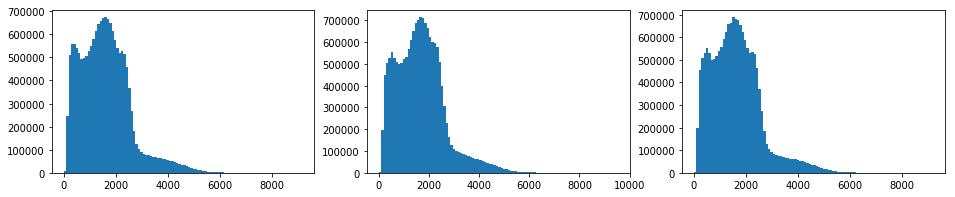

interactive(children=(IntSlider(value=83, description='z', max=167), Output()), _dom_classes=('widget-interact…

In [30]:
plt.figure(figsize=(16,3))
plt.subplot(1,3,1)
plt.hist(im0[im0>0].ravel(), 100)
plt.subplot(1,3,2)
plt.hist(im1[im1>0].ravel(), 100)
plt.subplot(1,3,3)
plt.hist(im1_scaled[im1_scaled>0].ravel(), 100);

z = np.concatenate((im0, im1, im1_scaled), axis=2)
myshow3d(z, figsize=(15,5))

## image registration

In [31]:
def register_im(im_fixed, im_moving, param_map=None, verbose=True):
    """SimpleElastix image registation. Register im_moving to im_fixed"""
    sim0 = sitk.GetImageFromArray(im_fixed)
    sim1 = sitk.GetImageFromArray(im_moving)
    
    if param_map is None:
        if verbose:
            print("using default 'transform' parameter map")
        param_map = sitk.GetDefaultParameterMap('translation')

    ef = sitk.ElastixImageFilter()
    ef.SetFixedImage(sim0)
    ef.SetMovingImage(sim1)
    ef.SetParameterMap(param_map)

    if verbose:
        print('image registration')
        tic = time.time()
    
    ef.Execute()
    
    if verbose:
        toc = time.time()
        print('registration done, {:.3} s'.format(toc - tic))

    sim_out = ef.GetResultImage()
    param_map_out = ef.GetTransformParameterMap()

    im_out = sitk.GetArrayFromImage(sim_out)

    return im_out, param_map_out

In [32]:
# spars = sitk.GetDefaultParameterMap('translation')
# spars['Transform'] = ['rigid']
# spars['MaximumNumberOfIterations'] = ['512']

spars = sitk.GetDefaultParameterMap('rigid')

im1_next = im1_scaled.copy()
im1_reg, spars_reg = register_im(im0, im1_next, param_map=spars, verbose=True)

# print('transform parameters: {}'.format(spars_res[0]['TransformParameters']))

image registration
registration done, 12.8 s


In [33]:
# plt.figure(figsize=(12,4))
# imshowreg(im0, im1, 'orig')

# plt.figure(figsize=(12,4))
# imshowreg(im0, im1_reg, 'registered')

# plt.figure(figsize=(12,4))
# imshowreg(im1, im1_reg, 'change')

def imshowcmp(im0, im1, title='', figsize=None):
    im0n = (im0 - np.min(im0))
    im1n = (im1 - np.min(im1))
    im0n = im0n / np.max(im0n)
    im1n = im1n / np.max(im1n)
    im = np.stack((im0n, im1n, 0*im1n), axis=3)
    myshow3d(im, title=title, figsize=figsize)
#     plt.subplot(1,2,1)
#     plt.imshow(im)
#     if title is not None:
#         plt.title('{} (overlay)'.format(title))
#     plt.subplot(1,2,2)
#     plt.imshow(np.abs(im0n - im1n))
#     if title is not None:
#         plt.title('{} (diff)'.format(title))
        

In [34]:
z = np.concatenate((np.abs(im0-im1_next), np.abs(im0-im1_reg)), axis=2)
imshowcmp(im0, im1_next, figsize=(5,5))
imshowcmp(im0, im1_reg, figsize=(5,5))
myshow3d(z, figsize=(10,10))


interactive(children=(IntSlider(value=83, description='z', max=167), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=83, description='z', max=167), Output()), _dom_classes=('widget-interact…

interactive(children=(IntSlider(value=83, description='z', max=167), Output()), _dom_classes=('widget-interact…